In [1]:
# Author: Tiago Tamagusko (tamagusko@gmail.com)
# Version: 3.0 (2022-11-15)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import pickle
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

from sklearn.model_selection import train_test_split

%matplotlib inline

In [2]:
# Regressors
DT_reg = DecisionTreeRegressor(random_state=42, max_depth=10)
RF_reg = RandomForestRegressor(random_state=42, max_depth=10)
XG_reg = xgb.XGBRegressor(random_state=42, max_depth=4)

In [3]:
# Data

IRI = pd.read_csv('data/raw/iri.csv')
IMPROVEMENT = pd.read_csv('data/raw/improvements.csv')
TRAFFIC = pd.read_csv('data/raw/aadtt.csv')
SN = pd.read_csv('data/raw/sn.csv')
PREC = pd.read_csv('data/raw/precipitation.csv')
TEMP = pd.read_csv('data/raw/temperature.csv')

In [4]:
# Cleaning data
IRI = IRI[['STATE_CODE', 'SHRP_ID', 'VISIT_DATE', 'MRI']]
TRAFFIC = TRAFFIC[['STATE_CODE', 'SHRP_ID', 'YEAR', 'AADTT_ALL_TRUCKS_TREND']]
SN = SN[['STATE_CODE', 'SHRP_ID', 'SN_VALUE']]
PREC = PREC.drop(['STATE_CODE_EXP', 'TOTAL_SNOWFALL_YR'], axis=1)
TEMP = TEMP.drop(['STATE_CODE_EXP', 'FREEZE_THAW_YR', 'FREEZE_INDEX_YR'], axis=1)

IRI['VISIT_DATE'] = pd.DatetimeIndex(IRI['VISIT_DATE']).year
IRI.rename(columns={'VISIT_DATE': 'YEAR'}, inplace=True)

In [5]:
# Processing climate data
CLIMATE = pd.merge(PREC, TEMP, on=[
                   'SHRP_ID', 'STATE_CODE', 'YEAR', 'VWS_ID']).drop(['VWS_ID'], axis=1)
# Processing data
DATA = pd.merge(IRI, CLIMATE, how='right', on=[
                'SHRP_ID', 'STATE_CODE', 'YEAR'])
DATA = pd.merge(DATA, TRAFFIC, how='right', on=[
                'SHRP_ID', 'STATE_CODE', 'YEAR'])
DATA = pd.merge(DATA, SN, how='right', on=['SHRP_ID', 'STATE_CODE'])
DATA.shape

(193915, 8)

In [6]:
# drop NA and duplicates
DATA = DATA.dropna()
DATA = DATA.drop_duplicates()
DATA.shape

(39471, 8)

In [7]:
# Sort dataset
DATA = DATA.sort_values(['YEAR'], ascending=[True])

In [8]:
# Save processed data
DATA.to_csv('data/processed/ltpp-data.csv', index=None, header=True)

In [9]:
# Drop unused columns
DATA = DATA.drop(['STATE_CODE', 'SHRP_ID'], axis=1)
# Rename columns
DATA = DATA.rename({'YEAR': 'Year',
                    'MRI': 'IRI',
                    'TOTAL_ANN_PRECIP': 'Precipitation',
                    'MEAN_ANN_TEMP_AVG': 'Temperature',
                    'AADTT_ALL_TRUCKS_TREND': 'AADTT',
                    'SN_VALUE': 'SN',
                    }, axis=1)

In [10]:
DATA.head()

,Year,IRI,Precipitation,Temperature,AADTT,SN
47181,1989,"1,39699995517731","151,600006103516","9,19999980926514",160,"2,70000004768372"
138695,1989,"1,57299995422363","1319,5","12,1000003814697",640,"6,09999990463257"
138694,1989,"1,64800000190735","1319,5","12,1000003814697",640,"6,09999990463257"
99608,1989,"0,874000012874603","807,099975585938","6,5",760,"7,90000009536743"
99607,1989,"0,953999996185303","807,099975585938","6,5",760,"7,90000009536743"


In [11]:
# Split into target and dataset
y = DATA['IRI']  # target
X = DATA.drop(['IRI'], axis=1)

In [12]:
X.shape

(39471, 5)

In [13]:
# Split in 75/25 (train/test)
train_threshold = 0.75

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=train_threshold, random_state=0)

In [14]:
DT_reg.fit(X_train, y_train)
RF_reg.fit(X_train, y_train)
XG_reg.fit(X_train, y_train)
print('Data trained! =)')

ValueError: could not convert string to float: '1150,59997558594'

In [15]:
# predict results
resultDT = DT_reg.predict(X_test)
resultRF = RF_reg.predict(X_test)
resultXG = XG_reg.predict(X_test)
print('Predicted! =)')

Predicted! =)


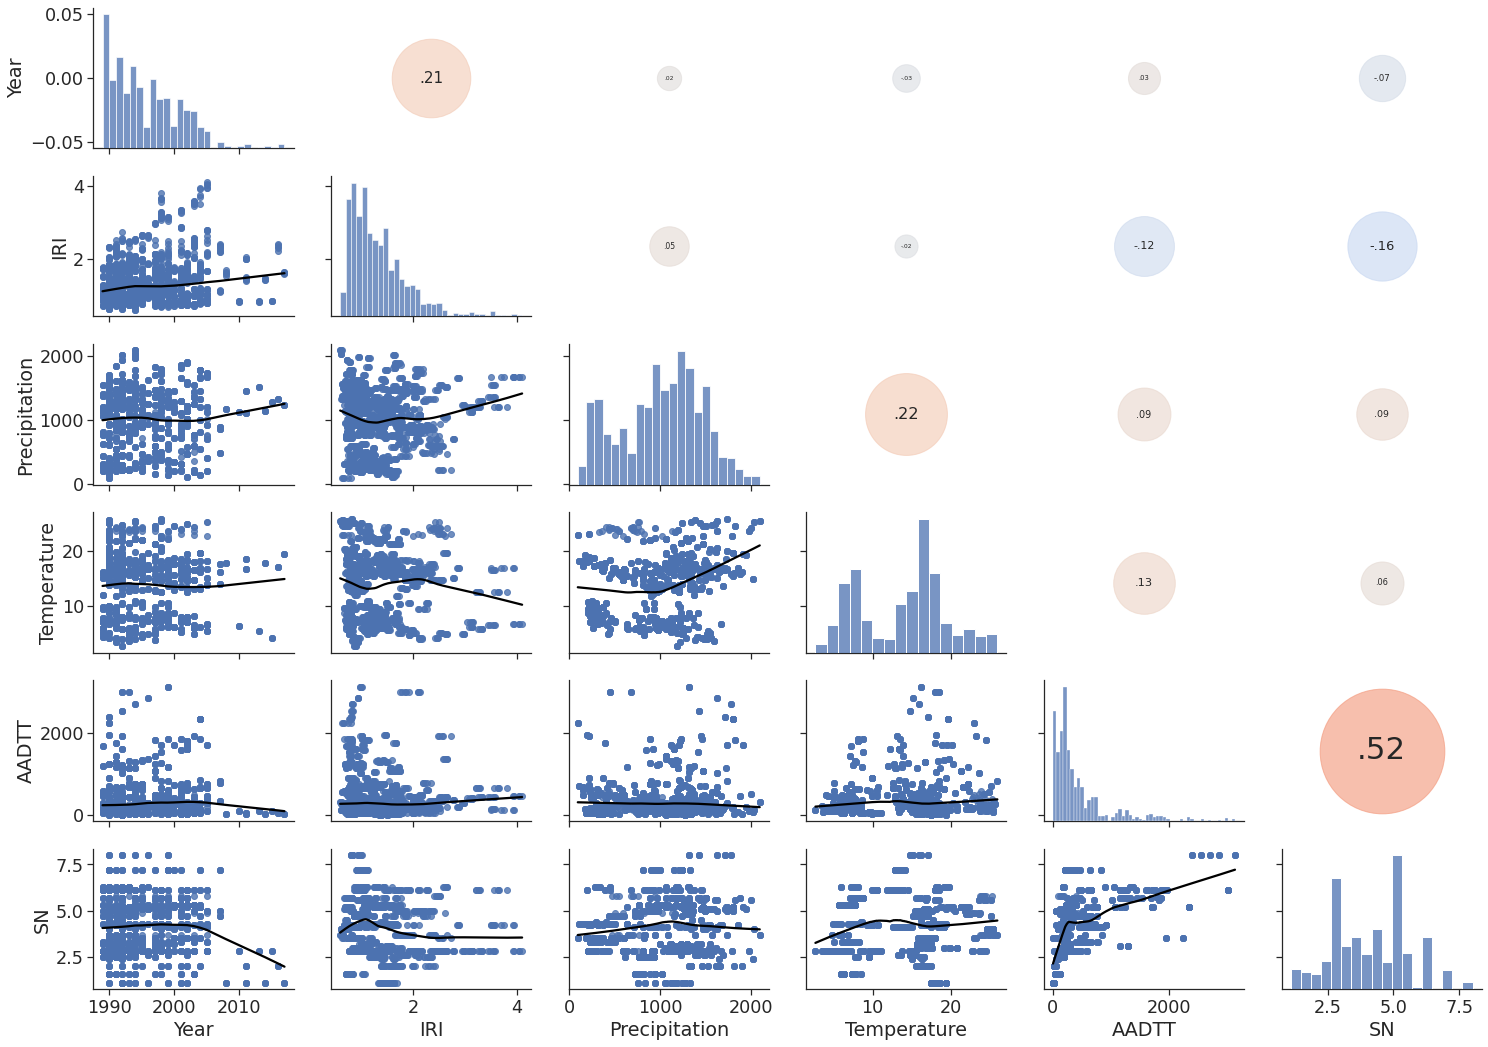

In [16]:
def corrdot(*args, **kwargs):
    corr_r = args[0].corr(args[1], 'pearson')
    corr_text = f"{corr_r:2.2f}".replace("0.", ".")
    ax = plt.gca()
    ax.set_axis_off()
    marker_size = abs(corr_r) * 30000
    ax.scatter([.5], [.5], marker_size, [corr_r], alpha=0.6, cmap="coolwarm",
               vmin=-1, vmax=1, transform=ax.transAxes)
    font_size = abs(corr_r) * 50 + 5
    ax.annotate(corr_text, [.5, .5,],  xycoords="axes fraction",
                ha='center', va='center', fontsize=font_size)

sns.set(style='ticks', font_scale=1.6)

g = sns.PairGrid(DATA, aspect=1.4, diag_sharey=False)
g.map_lower(sns.regplot, lowess=True, ci=False, line_kws={'color': 'black'})
g.map_diag(sns.histplot, kde_kws={'color': 'black'})
g.map_upper(corrdot)
g.savefig('results/scatter_matrixSNS.png')

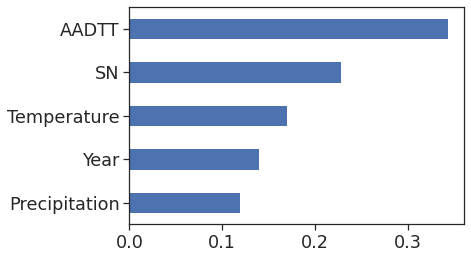

In [17]:
# feature importance for DT
importanceDT = DT_reg.feature_importances_
graphImportanceDT = pd.Series(importanceDT, index=X_train.columns).sort_values().plot.barh()
fig = graphImportanceDT.get_figure()
fig.savefig('results/importanceDT.png')

In [18]:
# summarize feature importance for DT
for i, v in enumerate(importanceDT):
    print('Feature: %s, Score: %.5f' % (X_train.columns[i], v))

Feature: Year, Score: 0.13944
Feature: Precipitation, Score: 0.11918
Feature: Temperature, Score: 0.16980
Feature: AADTT, Score: 0.34363
Feature: SN, Score: 0.22795


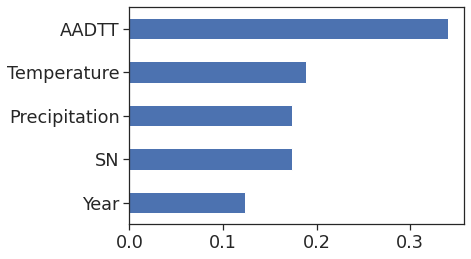

In [19]:
# feature importance for RF
importanceRF = RF_reg.feature_importances_
graphImportanceRF = pd.Series(importanceRF, index=X_train.columns).sort_values().plot.barh()

fig = graphImportanceRF.get_figure()
fig.savefig('results/importanceRF.png')

In [20]:
# summarize feature importance for RF
for i, v in enumerate(importanceRF):
    print('Feature: %s, Score: %.5f' % (X_train.columns[i], v))

Feature: Year, Score: 0.12328
Feature: Precipitation, Score: 0.17412
Feature: Temperature, Score: 0.18867
Feature: AADTT, Score: 0.34049
Feature: SN, Score: 0.17344


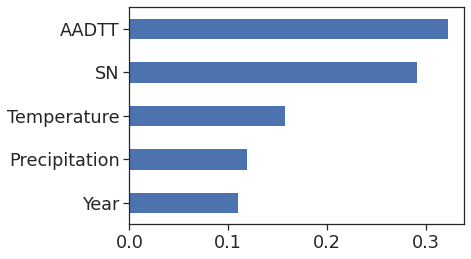

In [21]:
# feature importance for XGBoost
importanceXG = XG_reg.feature_importances_
graphImportanceXG = pd.Series(importanceXG, index=X_train.columns).sort_values().plot.barh()

fig = graphImportanceXG.get_figure()
fig.savefig('results/importanceXG.png')

In [22]:
# summarize feature importance for XGBoost
for i, v in enumerate(importanceXG):
    print('Feature: %s, Score: %.5f' % (X_train.columns[i], v))

Feature: Year, Score: 0.10990
Feature: Precipitation, Score: 0.11866
Feature: Temperature, Score: 0.15789
Feature: AADTT, Score: 0.32271
Feature: SN, Score: 0.29083


In [23]:
# Metrics
def r2(y_test, y_pred):
    return round(r2_score(y_test, y_pred), 2)


def rmse(y_test, y_pred):
    return round(np.sqrt(mean_squared_error(y_test, y_pred)), 2)


def mae(y_test, y_pred):
    return round(mean_absolute_error(y_test, y_pred), 2)


# r2
r2DT = r2(y_test, resultDT)
r2RF = r2(y_test, resultRF)
r2XG = r2(y_test, resultXG)

# rmse
rmseDT = rmse(y_test, resultDT)
rmseRF = rmse(y_test, resultRF)
rmseXG = rmse(y_test, resultXG)

# MAE
maeDT = mae(y_test, resultDT)
maeRF = mae(y_test, resultRF)
maeXG = mae(y_test, resultXG)

In [24]:
# calc. of samples
n_train = int(X.shape[0]*train_threshold)
n_test = int(X.shape[0])-n_train

In [25]:
# np.shape(TreeRegResult)[0]
x = np.arange(np.shape(y_test)[0])

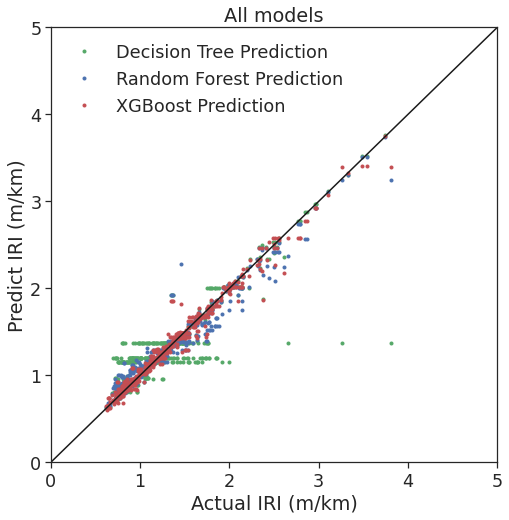

In [26]:
# plot all results
plt.rcParams['figure.figsize'] = (8, 8)
plt.plot(y_test, resultDT, 'g.', label='Decision Tree Prediction')
plt.plot(y_test, resultRF, 'b.', label='Random Forest Prediction')
plt.plot(y_test, resultXG, 'r.', label='XGBoost Prediction')
plt.xlabel('Actual IRI (m/km)')
plt.ylabel('Predict IRI (m/km)')
plt.plot(x, x, 'k-')  # identity line
# poor to fair threshold.. 2.7
# plt.hlines(2.7, 0, 2.7, colors='black', linestyles='dashed', linewidth=1.2)
# plt.vlines(2.7, 0, 2.7, colors='black', linestyles='dashed', linewidth=1.2)
plt.axis([0, 5, 0, 5])
leg = plt.legend()
leg.get_frame().set_linewidth(0.0)
plt.title("All models")
plt.savefig('results/treesComparison.png')
plt.show()

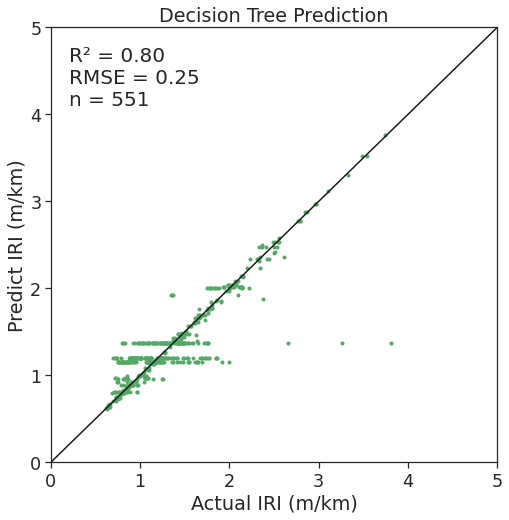

In [27]:
# plot DT results (test)
plt.rcParams['figure.figsize'] = (8,8)
plt.plot(y_test, resultDT, 'g.')
plt.xlabel('Actual IRI (m/km)')
plt.ylabel('Predict IRI (m/km)')
plt.plot(x, x, 'k-')  # identity line
plt.axis([0, 5, 0, 5])
s = "R² = %.2f \nRMSE = %.2f\nn = %i" % (r2DT, rmseDT, n_test)
plt.text(0.2, 4.1, s, fontsize=20)
plt.title("Decision Tree Prediction")
plt.savefig('results/DT.png')
plt.show()

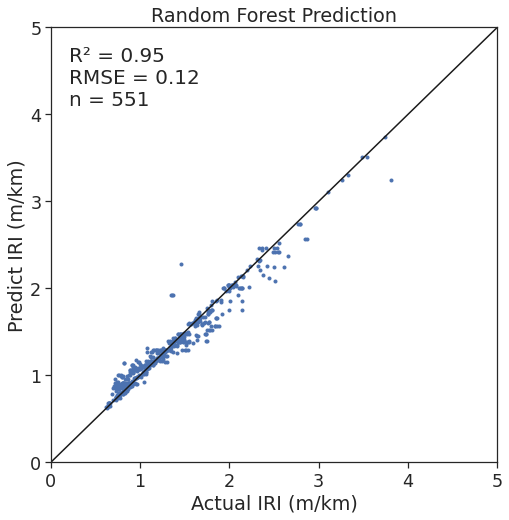

In [28]:
# plot RF results
plt.rcParams['figure.figsize'] = (8, 8)
plt.plot(y_test, resultRF, 'b.')
plt.xlabel('Actual IRI (m/km)')
plt.ylabel('Predict IRI (m/km)')
plt.plot(x, x, 'k-')  # identity line
plt.axis([0, 5, 0, 5])
s = "R² = %.2f \nRMSE = %.2f\nn = %i" % (r2RF, rmseRF, n_test)
plt.text(0.2, 4.1, s, fontsize=20)
plt.title("Random Forest Prediction")
plt.savefig('results/RF.png')
plt.show()

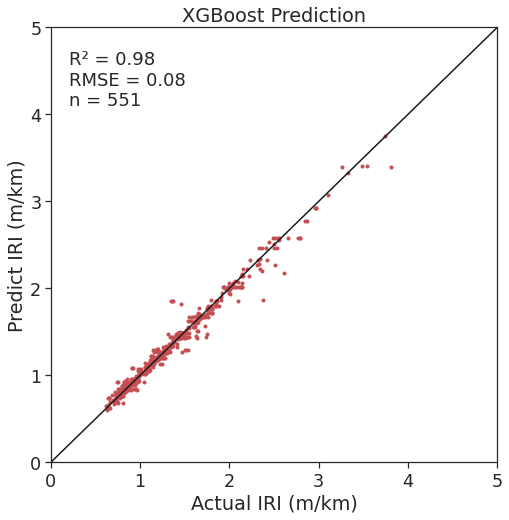

In [29]:
# plot XGBoost results
plt.rcParams['figure.figsize'] = (8, 8)
plt.plot(y_test, resultXG, 'r.', label='XGBoost Prediction')
plt.xlabel('Actual IRI (m/km)')
plt.ylabel('Predict IRI (m/km)')
plt.plot(x, x, 'k-')  # identity line
plt.axis([0, 5, 0, 5])
s = "R² = %.2f \nRMSE = %.2f\nn = %i" % (r2XG, rmseXG, n_test)
plt.text(0.2, 4.1, s, fontsize=18)
plt.title("XGBoost Prediction")
plt.savefig('results/XGBoost.png')
plt.show()

In [30]:
# save models
filenameDT = 'results/ltppIRI_DT.mlmodel'
pickle.dump(DT_reg, open(filenameDT, 'wb'))

filenameRF = 'results/ltppIRI_RF.mlmodel'
pickle.dump(DT_reg, open(filenameRF, 'wb'))

filenameXG = 'results/ltppIRI_XG.mlmodel'
pickle.dump(DT_reg, open(filenameXG, 'wb'))

In [31]:
# plt.figure(figsize=(15, 8))
# plot_tree(DT_reg, feature_names=list(X_train), node_ids=True, proportion=True, rounded=True, filled=True)

In [32]:
"""
plt.figure(figsize=(15, 8))
plot_tree(RF_reg.estimators_[0],
          feature_names=list(X_train),
          node_ids=True,
          proportion=True,
          rounded=True,
          filled=True)
"""

'\nplt.figure(figsize=(15, 8))\nplot_tree(RF_reg.estimators_[0],\n          feature_names=list(X_train),\n          node_ids=True,\n          proportion=True,\n          rounded=True,\n          filled=True)\n'

In [33]:
"""
xgb.plot_tree(XG_reg, num_trees=0)
plt.rcParams['figure.figsize'] = [280, 600]
plt.savefig('results/XGBoostTree_0.png')
plt.show()
"""

"\nxgb.plot_tree(XG_reg, num_trees=0)\nplt.rcParams['figure.figsize'] = [280, 600]\nplt.savefig('results/XGBoostTree_0.png')\nplt.show()\n"

In [34]:
r2DT, r2RF, r2XG

(0.8, 0.95, 0.98)

In [35]:
rmseDT, rmseRF, rmseXG

(0.25, 0.12, 0.08)

In [36]:
maeDT, maeRF, maeXG

(0.14, 0.07, 0.05)

In [37]:
# tuning depth of trees R2
depth = 10

max_depths = np.linspace(1, depth, depth, endpoint=True)

r2DT_results = []
r2RF_results = []
r2XG_results = []

rmseDT_results = []
rmseRF_results = []
rmseXG_results = []

maeDT_results = []
maeRF_results = []
maeXG_results = []

for max_depth in max_depths:
    dt = DecisionTreeRegressor(random_state=0, max_depth=max_depth)
    dt.fit(X_train, y_train)   
    DT_pred = dt.predict(X_test)   
    
    r2_DT = r2(y_test, DT_pred)
    rmse_DT = rmse(y_test, DT_pred)
    mae_DT = mae(y_test, DT_pred)
    
    r2DT_results.append(r2_DT)
    rmseDT_results.append(rmse_DT)
    maeDT_results.append(mae_DT)
    
    rf = RandomForestRegressor(random_state=0, max_depth=max_depth)
    rf.fit(X_train, y_train)   
    RF_pred = rf.predict(X_test)   
    
    r2_RF = r2(y_test, RF_pred)
    rmse_RF = rmse(y_test, RF_pred)
    mae_RF = mae(y_test, RF_pred)
    
    r2RF_results.append(r2_RF)
    rmseRF_results.append(rmse_RF)
    maeRF_results.append(mae_RF)
    
    xg = xgb.XGBRegressor(random_state=0, max_depth=int(max_depth))
    xg.fit(X_train, y_train)   
    XG_pred = xg.predict(X_test)
    
    r2_XG = r2(y_test, XG_pred)
    rmse_XG = rmse(y_test, XG_pred)
    mae_XG = mae(y_test, XG_pred)
    
    r2XG_results.append(r2_XG)
    rmseXG_results.append(rmse_XG)
    maeXG_results.append(mae_XG)

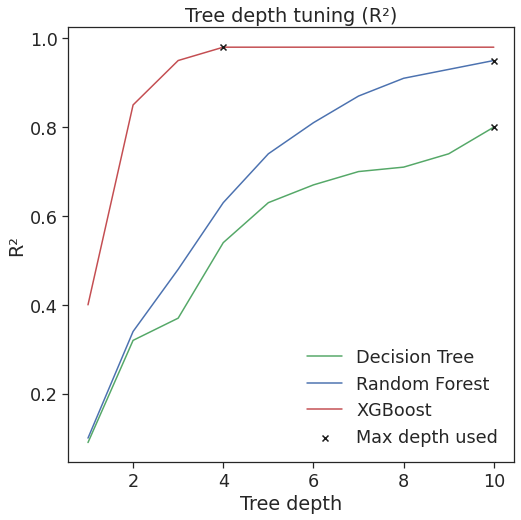

In [38]:
# Plot r2 graph
plt.rcParams['figure.figsize'] = (8, 8)
x_used = [10, 10, 4,]
y_used = [0.8, 0.95, 0.98]
plt.scatter(x_used, y_used, c='k', marker='x', label='Max depth used', zorder=2)
line1 = plt.plot(max_depths, r2DT_results, 'g', label='Decision Tree', zorder=1)
line2 = plt.plot(max_depths, r2RF_results, 'b', label='Random Forest', zorder=1)
line3 = plt.plot(max_depths, r2XG_results, 'r', label='XGBoost', zorder=1)

plt.ylabel('R²')
plt.xlabel('Tree depth')
leg = plt.legend()
leg.get_frame().set_linewidth(0.0)
plt.title("Tree depth tuning (R²)")

plt.savefig('results/depthTreeTuning_R2.png')
plt.show()

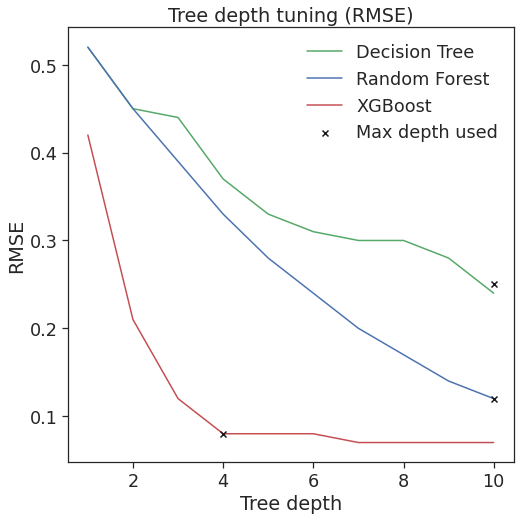

In [39]:
# Plot r2 graph
plt.rcParams['figure.figsize'] = (8, 8)
x_used = [10, 10, 4,]
y_used = [0.25, 0.12, 0.08]
plt.scatter(x_used, y_used, c='k', marker='x', label='Max depth used', zorder=2)
line1 = plt.plot(max_depths, rmseDT_results, 'g', label='Decision Tree', zorder=1)
line2 = plt.plot(max_depths, rmseRF_results, 'b', label='Random Forest', zorder=1)
line3 = plt.plot(max_depths, rmseXG_results, 'r', label='XGBoost', zorder=1)

plt.ylabel('RMSE')
plt.xlabel('Tree depth')
leg = plt.legend()
leg.get_frame().set_linewidth(0.0)
plt.title("Tree depth tuning (RMSE)")

plt.savefig('results/depthTreeTuning_RMSE.png')
plt.show()

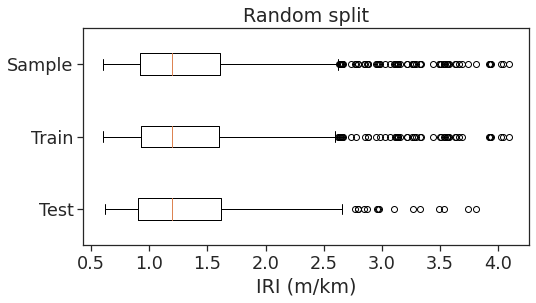

In [40]:
data = [y_test, y_train, DATA['IRI']]
plt.rcParams['figure.figsize'] = (8, 4)
fig, ax = plt.subplots()
ax.boxplot(data, labels=['Test', 'Train', 'Sample'], vert=False)
ax.set_xlabel('IRI (m/km)')
plt.savefig('results/box_plot_random_split.png')
plt.title("Random split")
plt.show()

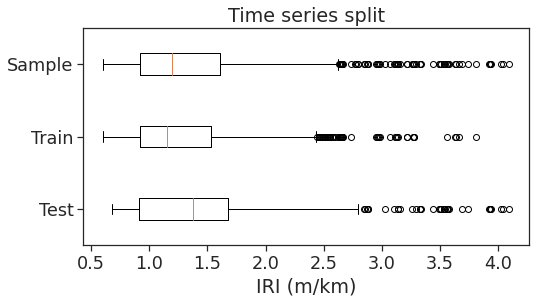

In [41]:
# View data split temporal
y_train_ts = y[:int(DATA['IRI'].shape[0]*0.7)]
y_test_ts = y[int(DATA['IRI'].shape[0]*0.7):]

data = [y_test_ts, y_train_ts, DATA['IRI']]
plt.rcParams['figure.figsize'] = (8, 4)
fig, ax = plt.subplots()
ax.boxplot(data, labels=['Test', 'Train', 'Sample'], vert=False)
ax.set_xlabel('IRI (m/km)')
plt.title("Time series split")
plt.savefig('results/box_plot_ts_split.png')
plt.show()

In [42]:
DT_reg

DecisionTreeRegressor(max_depth=10, random_state=42)